# Preprocessing Test Audio Files
## (for the HVA 280 connectors)

In [2]:
# all libraries used in this notebook

import os.path
from pathlib import Path
import re
import librosa
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib

In [3]:
# import necessary functions from the folder "05_Utilities"

cwd = str(Path.cwd()) ## current working directory, should be the path to "01_Dataset", in which this notebook is located
parent_dir = str(Path(cwd).parent) ## parent dir of the current working directory, should be the project directory
utilities_dir_full_path = os.path.join(parent_dir, "05_Utilities") ## full path to the "05_Utilities" folder

# import moduls for audio file processing and mel-spectrogram plotting

sys.path.append(utilities_dir_full_path) ## add the path of the "05_Utilities" folder to the sys.path list

import audioProcessing ## modul for audio file processing and mel-spectrogram generation
import spectrogramPlotting ## modul for mel-spectrogram visualization
import sharedValues ## modul for shared variables between the classes

importlib.reload(audioProcessing)
importlib.reload(spectrogramPlotting)
importlib.reload(sharedValues)

# make instances of the classes in the modules
#processAudio = processAudio()
processAudio = audioProcessing.processAudio()
spectrogramPlotter = spectrogramPlotting.spectrogramPlotter()
sharedValuesConfig =sharedValues.sharedValuesConfig()

In [4]:
# list all audio file datasets in folder "01_Data/01_audioDatasets"

audio_datasets_main_dir_name = "01_audioDatasets"
audio_datasets_main_dir = os.path.join(cwd, audio_datasets_main_dir_name)
audio_datasets = []

if os.path.exists(audio_datasets_main_dir):
    for i in os.listdir(audio_datasets_main_dir):
        #if folder name does not start with a dot
        if i[0] != ".": 
            audio_datasets.append(i)
    audio_datasets = sorted(audio_datasets) # sort the list of audio datasets
else:
    print("\"01_audioDatasets\" directory does not exist or is not in the correct location.")

print(audio_datasets)

['01_Ethernet', '02_Ethernet_Test', '03_HVA280', '04_HVA280_Test', '05_HVA630', '06_HVA630_Test', '07_Noise_Samples', 'voice_memo_loc_mac.txt']


In [5]:
# select dataset (from test datasets)
# dataset_num = 3 for HVA 280 connector

dataset_num = 3
print("Selected dataset: ", audio_datasets[dataset_num])

Selected dataset:  04_HVA280_Test


In [35]:
# add audio files from selected dataset to a list

# sorting function by numbers in the name
def sort_key_func(file_name):
        numbers = re.findall(r'_(\d+)', file_name)
        if numbers:
            return int(numbers[0])
        return file_name

audio_dataset_dir_path = os.path.join(cwd, audio_datasets_main_dir_name, audio_datasets[dataset_num])
audio_files = [f for f in os.listdir(audio_dataset_dir_path) if f.endswith('.m4a')]
audio_files_sorted = sorted(audio_files, key=sort_key_func)

print(f"Dataset length: {len(audio_files_sorted)}")

i = 0
print("First 5 files in the selected dataset:")
while i < 5:
    print(audio_files_sorted[i])
    i += 1

label_file = [f for f in os.listdir(audio_dataset_dir_path) if f.endswith('.txt')][0]
label_file_path = os.path.join(audio_dataset_dir_path, label_file)

with open(label_file_path, "r") as file:
    click_time_labels = [line.strip() for line in file]

print(f"Labels length: {len(click_time_labels)}")
print("First 5 labels: ", click_time_labels[:5])

Dataset length: 30
First 5 files in the selected dataset:
HVA280_test_1.m4a
HVA280_test_2.m4a
HVA280_test_3.m4a
HVA280_test_4.m4a
HVA280_test_5.m4a
Labels length: 30
First 5 labels:  ['18.31', '20.61', '21.81', '33.21', '18.27']


In [36]:
# constant shared parameters (used in real-time detection as well)

sampling_rate = sharedValuesConfig.SAMPLING_RATE ## sampling rate of the audio files
chunk_size = sharedValuesConfig.CHUNK_SIZE ## number of samples in one chunk of audio data
resolution = sharedValuesConfig.RESOLUTION ## time resolution of the mel-spectrogram
spectrogram_columns_per_chunk = sharedValuesConfig.SPECTROGRAM_COLUMNS_PER_CHUNK ## number of spectrogram columns in one chunk of audio data
hop_length = sharedValuesConfig.HOP_LENGTH ## number of samples between successive frames in the STFT
n_mels = sharedValuesConfig.N_MELS ## number of mel bands (rows in the mel-scaled spectrogram)
f_min = sharedValuesConfig.F_MIN ## minimum frequency in Hz
f_max = sharedValuesConfig.F_MAX ## maximum frequency in Hz
dB_ref = sharedValuesConfig.DB_REF ## reference value for dB conversion
a_squere_min = sharedValuesConfig.A_SQUERE_MIN ## min value for dB conversion
top_dB_abs = sharedValuesConfig.TOP_DB_ABS ## maximum dB value
dB_ref = sharedValuesConfig.DB_REF ## reference value for dB conversion
a_squere_min = sharedValuesConfig.A_SQUERE_MIN ## min value for dB conversion
top_dB_abs = sharedValuesConfig.TOP_DB_ABS ## maximum dB value
chunks_per_plot = sharedValuesConfig.CHUNKS_PER_PLOT ## number of chunks per plot
samples_per_plot = sharedValuesConfig.SAMPLES_PER_PLOT ## number of samples per plot

/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/05_Utilities/audioProcessing.py:55: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file, sr=sampling_rate)
/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


signal type: <class 'numpy.ndarray'>
signal shape: (1002112,)
D_mel_dB_shape: (128, 1958)


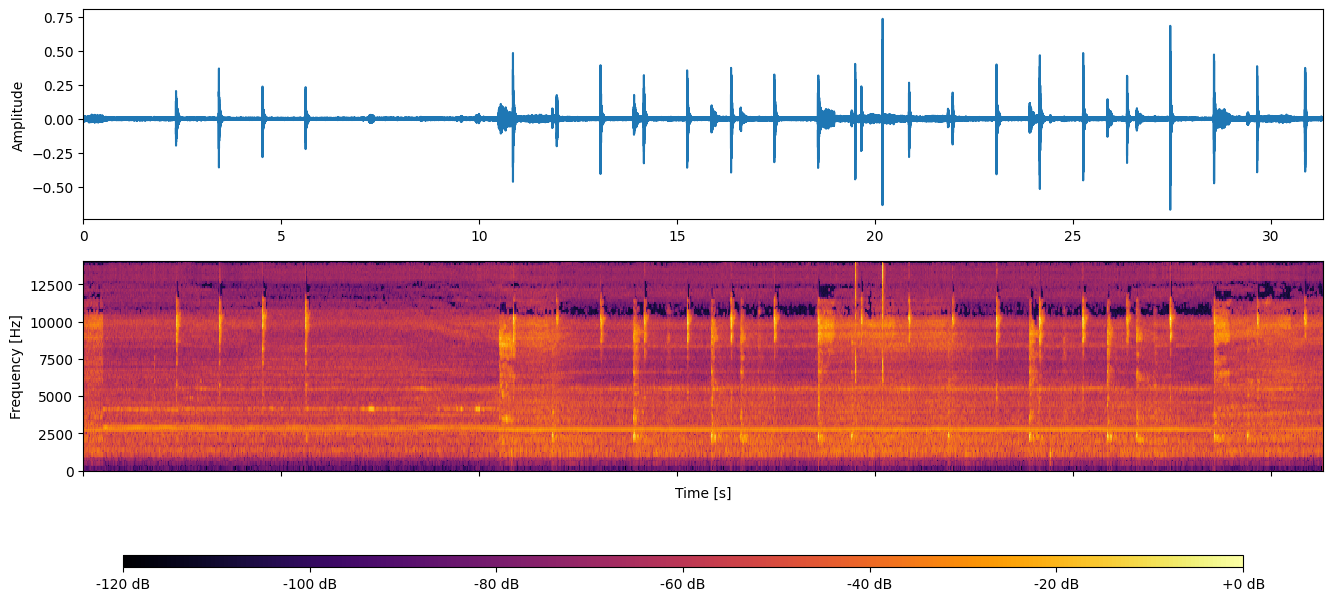

In [43]:
# plot the wave and mel spectrogram of an audio file from the selected dataset

file_id_num = 20 # selected file ID number

if file_id_num < len(audio_files_sorted):
    audio_file_path = os.path.join(audio_dataset_dir_path, audio_files_sorted[file_id_num])
    signal, time, D_mel, D_mel_dB = processAudio.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)
    print(f"signal type: {type(signal)}")
    print(f"signal shape: {signal.shape}")
    print(f"D_mel_dB_shape: {D_mel_dB.shape}")
    spectrogramPlotter.plot_single_wave_and_mel_spectrogram(signal, time, D_mel_dB, top_dB_abs, f_min, f_max, n_mels, sampling_rate)
else:
    print("File ID out of range")

In [44]:
# indices of the first clicks

first_click_index_labels = []
second_click_index_labels = []

time_difference = 0.7 # seconds, time difference between the first and second click (from the automated labeling)
time_difference_indices = int(time_difference * sampling_rate)

for click_time_label in click_time_labels:
    click_time = float(click_time_label) + 0.032 ## added 32 ms to click times because of the padding taht was added to the audio files (1024 samples at 32 kHz = 32 ms)
    first_click_index = int(click_time * sampling_rate)
    second_click_index = first_click_index + time_difference_indices
    first_click_index_labels.append(first_click_index)
    second_click_index_labels.append(second_click_index)

print(first_click_index_labels[:5])
print(second_click_index_labels[:5])

[586944, 660544, 698944, 1063744, 585664]
[609344, 682944, 721344, 1086144, 608064]


1.024
19.492 20.192
0.512
0.512
19.33 20.354


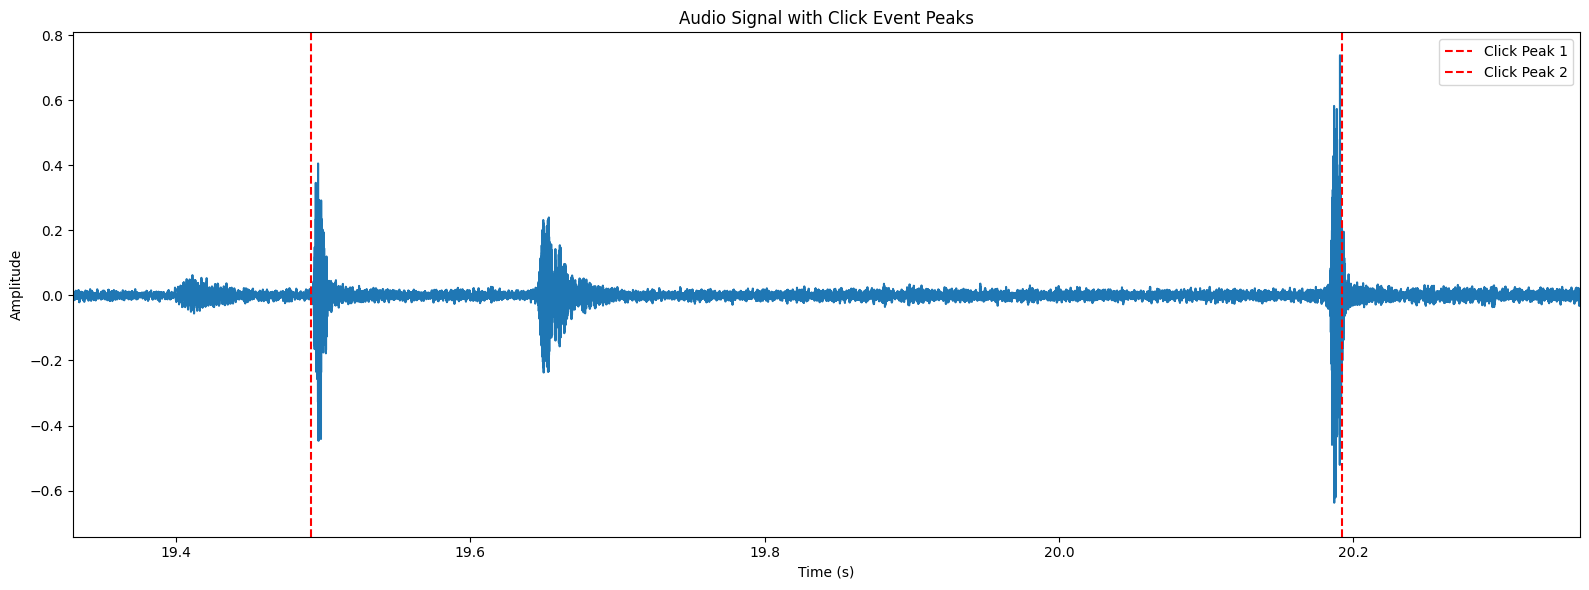

In [45]:
# plot the signal interval around the peak time of the click event for the same audio file in the selected dataset as the spectrogram plot above

time_interval = (chunk_size/sampling_rate) * 8 # this will be the window size in the real time detection --> 8 chunks with 4096 samples each --> with the 32 kHz sampling rate this is 1.024 seconds
print(time_interval)

peak_time_1 = first_click_index_labels[file_id_num]/sampling_rate 
peak_time_2 = second_click_index_labels[file_id_num]/sampling_rate
print(peak_time_1, peak_time_2)

interval = time_interval/2 # for setting the x mina and max limits of the plot --> peak time +/- interval
print(interval)

spectrogramPlotter.plot_signal_interval_with_2_peaks(signal, time, peak_time_1, peak_time_2, interval)

In [46]:
# calculating signals and signal times for the selected dataset

# calculate peak time of the click event for each audio file in the selected dataset
def calc_signal_times(audio_files_sorted, audio_dataset_dir, sampling_rate):
    signals = [] # audio wave forms
    signal_times = [] # time stamps in seconds for all samples in an audio file 

    for i in range(len(audio_files_sorted)):
        audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[i])
    
        signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)

        n_samples = len(signal) ## number of all samples in the signal
        duration = n_samples / sampling_rate ## duration of the signal in seconds
        time = np.linspace(0, duration, n_samples) ## time vector for plotting

        signals.append(signal)
        signal_times.append(time)

    return signals, signal_times

# get the signals, signal times
signals, signal_times  = calc_signal_times(audio_files_sorted, audio_dataset_dir_path, sampling_rate)

/var/folders/bj/7ggffpq918g65k1n35l6t6t40000gn/T/ipykernel_26033/2863471490.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)
/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [48]:
print("Number of signals: ", len(signals))
print("Number of signal times: ", len(signal_times))
# shape of the signal
print("Shape of the first signal: ", signals[0].shape)

Number of signals:  30
Number of signal times:  30
Shape of the first signal:  (956374,)


In [49]:
window_size = sharedValuesConfig.WINDOW_SIZE_LONG # 0.512 seconds, corresponds to 4 chunks with 4096 samples each, larger than the click event duration
## -> 32 columns in the spectrogram
step_size = sharedValuesConfig.STEP_SIZE ## in this case 8, number of spectrogram columns in the step size
## corresponds 0.128 seconds --> 1/2 overlap

print("Window size: ", window_size)
print("Step size: ", step_size)

Window size:  64
Step size:  8


In [61]:
# in the same way as it is generated during the real time detection

#spec_chunk_dataset = []
#spec_chunk_labels = []
#signal_chunks = []
#time_chunks = []

def createSpectrogramDataset(signals, signal_times, first_click_index_labels, second_click_index_labels):

    for i in range(len(audio_files_sorted)):

        melspec_full = np.zeros((n_mels, int(samples_per_plot / hop_length))) # initialize mel spectrogram
        signal_full = np.zeros(samples_per_plot) # initialize signal
        time_full = np.zeros(samples_per_plot) # initialize time
        old_mic_input = np.zeros(chunk_size).astype(np.float32)

        detection_window = window_size * hop_length
        signal_step_size = step_size * hop_length

        spec_chunk_dataset = []
        spec_chunk_labels = []

        audio_file = audio_files_sorted[i]
        #print(audio_file)
        signal = signals[i]
        
        time = signal_times[i]
        first_click_index = first_click_index_labels[i]
        second_click_index = second_click_index_labels[i]
        
        for start_idx in range(0, len(signal) - detection_window, signal_step_size):
            end_idx = start_idx + signal_step_size
            
            input_signal_chunk = signal[start_idx:end_idx]
            input_time_chunk = time[start_idx : end_idx]

            new_mic_input = input_signal_chunk
            
            mid_mic_signal = np.concatenate((old_mic_input[(chunk_size//2):], new_mic_input[:(chunk_size//2)]))
            mid_signal_time = np.concatenate((input_time_chunk[(chunk_size//2):], input_time_chunk[:(chunk_size//2)]))

            _, _, _, D_mel_dB_new = processAudio.get_mel_spectrogram(new_mic_input, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)
            _, _, _, D_mel_dB_mid = processAudio.get_mel_spectrogram(mid_mic_signal, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)

            new_spectrogram_chunk = np.concatenate((D_mel_dB_mid[:, 4:5], D_mel_dB_new[:, 1:8]), axis=1)

            new_signal_chunk = np.concatenate((mid_mic_signal[4*hop_length:5*hop_length], new_mic_input[hop_length:8*hop_length]))
            new_time_chunk = np.concatenate((mid_signal_time[4*hop_length:5*hop_length], input_time_chunk[hop_length:8*hop_length]))

            melspec_full = np.roll(melspec_full, -new_spectrogram_chunk.shape[1], axis=1)
            melspec_full[:, -new_spectrogram_chunk.shape[1]:] = new_spectrogram_chunk

            signal_full = np.roll(signal_full, -new_signal_chunk.shape[0])
            signal_full[-new_signal_chunk.shape[0]:] = new_signal_chunk

            time_full = np.roll(time_full, -new_time_chunk.shape[0])
            time_full[-new_time_chunk.shape[0]:] = new_time_chunk

        
            if end_idx-detection_window-hop_length < first_click_index and second_click_index < end_idx-hop_length:
                label = 1
            else:
                label = 0

            spectrogram_chunk = melspec_full[:, -window_size:]
            signal_chunk = signal_full[-window_size*hop_length:]
            time_chunk = time_full[-window_size*hop_length:]

            spec_chunk_dataset.append(spectrogram_chunk)
            spec_chunk_labels.append(label)

            old_mic_input = new_mic_input

        # save individual datasets
        # split audio file name and extension
        filename = os.path.splitext(audio_file)[0] + "_dataset.npz"
        save_directory_path = audio_dataset_dir_path
        file_fullpath = os.path.join(save_directory_path, filename)

        #create array adn remove the first 7 chunks and labels as these include the initial zero signal
        spec_chunk_dataset_arr = np.array(spec_chunk_dataset)[7:]
        spec_chunk_labels_arr = np.array(spec_chunk_labels)[7:]

        np.savez(file_fullpath, spec_chunks=spec_chunk_dataset_arr, labels=spec_chunk_labels_arr)

    #return spec_chunk_dataset, spec_chunk_labels

createSpectrogramDataset(signals, signal_times, first_click_index_labels, second_click_index_labels)

In [62]:
# list saved datasets

saved_datasets = [f for f in os.listdir(audio_dataset_dir_path) if f.endswith('.npz')]
saved_datasets_sorted = sorted(saved_datasets, key=sort_key_func)
print(saved_datasets_sorted[:5])
print(len(saved_datasets_sorted))

['HVA280_test_1_dataset.npz', 'HVA280_test_2_dataset.npz', 'HVA280_test_3_dataset.npz', 'HVA280_test_4_dataset.npz', 'HVA280_test_5_dataset.npz']
30


In [69]:
# load first saved dataset

dataset_to_load_id = 20

dataset_file_path = os.path.join(audio_dataset_dir_path, saved_datasets_sorted[dataset_to_load_id])
dataset = np.load(dataset_file_path)
loaded_spec_chunks = dataset['spec_chunks']
loaded_labels = dataset['labels']
print(loaded_spec_chunks[0].shape)
print(len(loaded_spec_chunks))
print(len(loaded_labels))

# count the number of positive labels in numpy array
print(np.count_nonzero(loaded_labels == 1))

# indices containing chunks with positive labels
print([i for i, x in enumerate(loaded_labels) if x == 1][:6])

(128, 64)
230
230
3
[150, 151, 152]


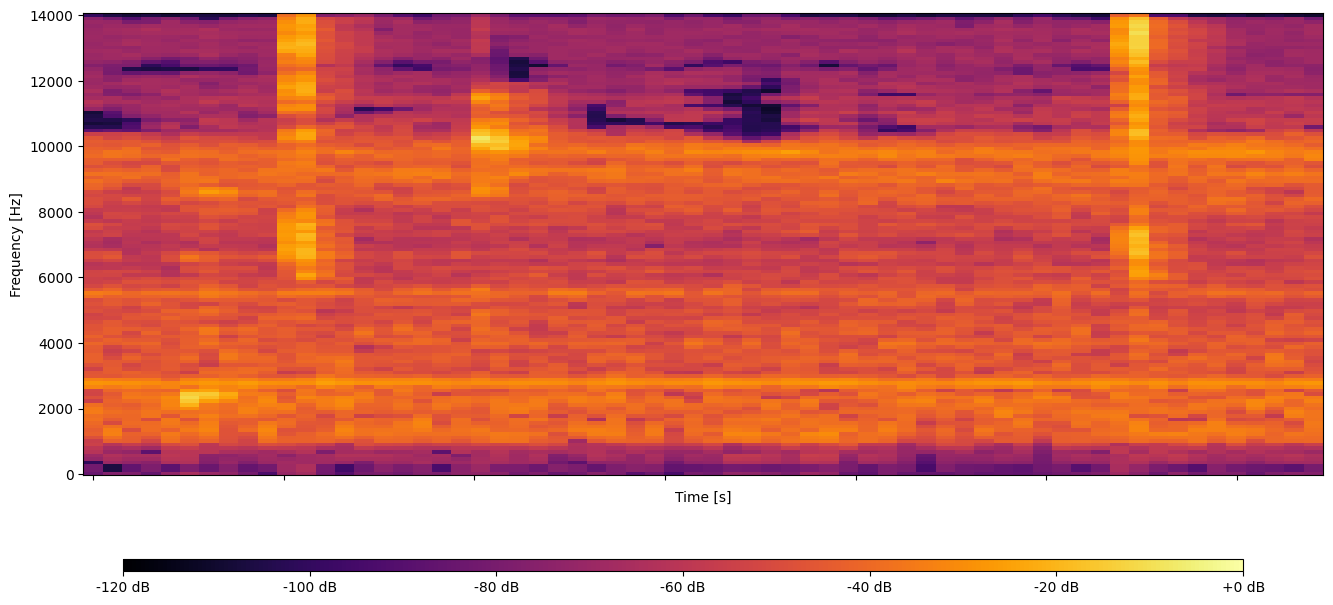

In [71]:
# plot out one spectrogram chunk
chunk_to_plot_id = 151
spectrogramPlotter.plot_single_mel_spectrogram(loaded_spec_chunks[chunk_to_plot_id], top_dB_abs, f_min, f_max, n_mels)